In [1]:
import numpy as np
import sklearn
import pickle
from sklearn.ensemble import RandomForestClassifier
from preprocess import *
from sklearn.preprocessing import MinMaxScaler    
from sklearn.metrics import accuracy_score

# 스켈레톤이 아주 stochastic하기 때문에 5장 중 median으로 smoothing

In [2]:
base_dir = "/home/hoseung/Work/data/BBS/"

action = 1
nframe = 6
frame_skip = 20
feature_ready=False
cam = "e"

In [3]:
### BBS data set
main_list = f"whoismain/whoismain_{cam}_txt/main_list_{cam}_{action}.txt"
npy_list = merge_main_npy(base_dir+main_list, prefix=base_dir + f"npy_{cam}/")

scene = np.load(npy_list[0]['npy'])
data = []
label=[]

for i, fn_npy in enumerate(npy_list):
    if fn_npy['main'] in [0,1]:
        try:
        #if True:
            scene = np.load(fn_npy['npy'])
            for j in range(frame_skip):
                sub = smoothed_frame_N(scene, nframe=nframe, shift=j)

                # feature 기록
                rav_sub = ravel_rec(sub)
                data.append(rav_sub)
                label.append(fn_npy['score'])

        except:
            print("Main person was guessed, but not actually detected... ", fn_npy['npy'])


features = [ff for i in range(nframe) for ff in sub.dtype.names if ff not in "frame" ]
features = np.array(features)

data = np.stack(data)
label = np.array(label)
print(action, data.shape)

1 (8400, 180)


# Test data

In [250]:
from glob import glob

testdata_dir = "/home/hoseung/Work/data/BBS/TestData/BT/"

score = 2 # 2 or 4

fns = glob(testdata_dir + f"{cam}_*_{action}_{score}_skeleton.pickle")

test_raw = [pickle.load(open(fn, "rb")) for fn in fns]

In [251]:
fns

['/home/hoseung/Work/data/BBS/TestData/BT/e_16141433_1_2_skeleton.pickle',
 '/home/hoseung/Work/data/BBS/TestData/BT/e_1617504_1_2_skeleton.pickle',
 '/home/hoseung/Work/data/BBS/TestData/BT/e_16175147_1_2_skeleton.pickle',
 '/home/hoseung/Work/data/BBS/TestData/BT/e_16141451_1_2_skeleton.pickle',
 '/home/hoseung/Work/data/BBS/TestData/BT/e_16174854_1_2_skeleton.pickle']

## preprocess: 원래는 QThreadObj.select_sk*() 함수 안에서 돌아가는 부분

In [252]:
from bbsQt.model import kinect_utils as ku 
from bbsQt.model import rec_utils as ru

In [253]:
skarr = test_raw[0]
Nframe = 6

sub = ru.smoothed_frame_N(skarr, 
                        nframe=Nframe, 
                        shift=1)
new_sks = ru.ravel_rec(sub)[np.newaxis, :]

# 두 종류의 데이터셋을 잘~ 표준화하기 

## Depth 카메라의 전체 영역은 512 x 512 픽셀이고, 실제로는 512 내부의 둥근 원형의 영역, 반지름이 대략 200 정도? 

### -> 중심은 (256,256)으로 가정

In [108]:
import matplotlib.pyplot as plt 
#import seaborn as sns; sns.set()

In [109]:
data.shape

(8400, 180)

In [110]:
# x, y 좌표 분리
xdata = data[:,::2]
ydata = data[:,1::2]

In [111]:
xsk = skeleton[0][::2]
ysk = skeleton[0][1::2]

In [112]:
def plot_band(data, frac_lower = 0.2, frac_upper = 0.8):
    lower, upper = np.quantile(data, [frac_lower, frac_upper], axis=0)
    
    x = np.arange(len(lower))

    plt.fill_between(x, lower, upper, color='b', alpha=0.2)
    represent = np.median(data, axis=0)
    plt.plot(x, represent)    

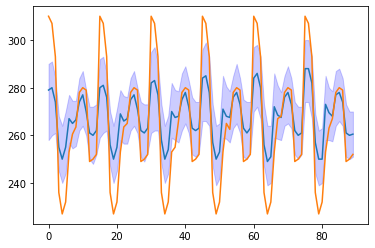

In [113]:
plot_band(xdata)
plt.plot(xsk)
plt.show()

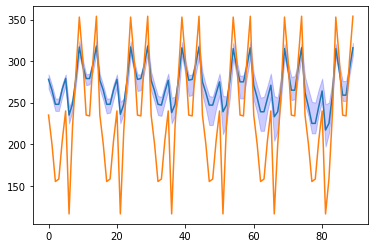

In [114]:
plot_band(ydata, 0.05, 0.95)
plt.plot(ysk)
plt.show()

1. 특정 뼈 길이로 normalize
2. 중심 위치 이동 

# joint 이름

In [115]:
from bbsQt.model import BBS_pp_utils as bbpp
# 키 normalize 
## 어깨 - 팔꿈치 / 허벅지 / 종아리 
common_joints = bbpp.COMMON_JOINT

In [116]:
common_joints

array(['l_hand', 'l_elbow', 'l_shoulder', 'r_shoulder', 'r_elbow',
       'r_hand', 'head', 'neck', 'pelvis', 'l_foot', 'l_knee', 'l_hip',
       'r_hip', 'r_knee', 'r_foot'], dtype='<U10')

In [117]:
xy_joint_inds = dict([(name,i) for i, name in enumerate([prefix+cj for cj in common_joints for prefix in ["x", "y"]])])

In [118]:
def joint_length(joint, j1:str, j2:str):
    """measure lentgh of a joint from j1 to j2"""
    x1 = joint[xy_joint_inds["x"+j1]]
    x2 = joint[xy_joint_inds["x"+j2]]
    y1 = joint[xy_joint_inds["y"+j1]]
    y2 = joint[xy_joint_inds["y"+j2]]
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)
    

## Centering

In [130]:
# To do: 0이 아닌 점들에 대해서만.. 
# 좌-우 중 하나만 0이면 반대편도 같이 제외
def shift_to_zero(skeleton, nframe=2, njoints=30):
    early_frame_x = skeleton[:nframe*njoints:2]
    early_frame_y = skeleton[1:nframe*njoints:2]

    ix_nz = np.nonzero(early_frame_x)
    iy_nz = np.nonzero(early_frame_y)

    mean_x = np.mean(early_frame_x[ix_nz])
    mean_y = np.mean(early_frame_y[iy_nz])
    
    skeleton[::2] -= mean_x 
    skeleton[1::2] -= mean_y 
    return skeleton

In [242]:
# Shift to around (256,256)
skeleton[0] = shift_to_zero(skeleton[0])
# iterate 
#xdata = 

In [133]:
xdata.shape

(8400, 90)

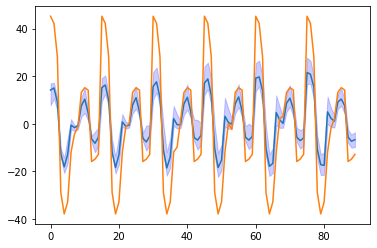

In [137]:
plot_band(xdata)
plt.plot(skeleton[0][::2])
plt.show()

In [135]:
for joint in data:
    joint = shift_to_zero(joint)

### Skeleton은 2D 모양임 (tensor input이어서)

In [164]:
joint_length(skeleton[0][30:60], 'l_elbow', 'l_shoulder')

47.1274866717927

In [163]:
joint_length(skeleton[0][:30], 'r_elbow', 'r_shoulder')

46.872166581031856

In [61]:
print(joint_length(skeleton[0][:30], 'l_hip', 'l_knee'),
      joint_length(skeleton[0][:30], 'r_hip', 'r_knee'))

68.00735254367721 67.00746227100382


In [62]:
print(joint_length(skeleton[0][:30], 'l_foot', 'l_knee'),
      joint_length(skeleton[0][:30], 'r_foot', 'r_knee'))

50.039984012787215 53.03772242470448


In [212]:
def arms_and_legs(skeleton, topk=2):
    """
    get representative length of arms and legs
    """
    lls = []
    rls = []
    las = []
    ras = []
    for sk in skeleton.reshape(-1, 30):
        lls.append(joint_length(sk, 'l_hip', 'l_knee'))
        rls.append(joint_length(sk, 'r_hip', 'r_knee'))
        las.append(joint_length(sk, 'l_elbow', 'l_shoulder'))
        ras.append(joint_length(sk, 'r_elbow', 'r_shoulder')) 

    out = []    
    for arr in (lls, rls, las, ras):
        out.append(arr[np.argsort(arr)[-topk]])
    return out


PAIRS = {'larm':('l_elbow', 'l_shoulder'),
         'rarm':('r_elbow', 'r_shoulder'), 
         'lleg':('l_hip', 'l_knee'),
         'rleg':('r_hip', 'r_knee'),
         'body':('neck', 'pelvis')}

def measure_lengths(skeleton, topk=2):
    """
    get representative lengths of joints
    """
    
    out = []
    for pair in PAIRS:
        lengths = []
        for sk in skeleton.reshape(-1, 30):
            lengths.append(joint_length(sk, *PAIRS[pair]))
            
        out.append((pair,lengths[np.argsort(lengths)[-topk]]))
            
    return dict(out)

In [217]:
armlegarr = np.zeros(len(data), dtype=[(pp, float) for pp in PAIRS])
for i, dd in enumerate(data):
    body = measure_lengths(dd)
    for pp in PAIRS:
        armlegarr[i][pp] = body[pp]#

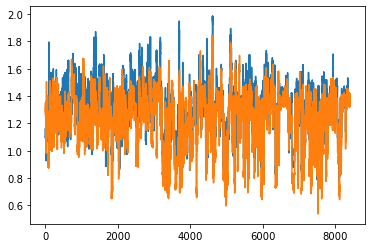

In [218]:
plt.plot(armlegarr['lleg']/armlegarr['larm'])
#plt.plot()
plt.plot(armlegarr['rleg']/armlegarr['rarm'])
#plt.plot()
plt.show()

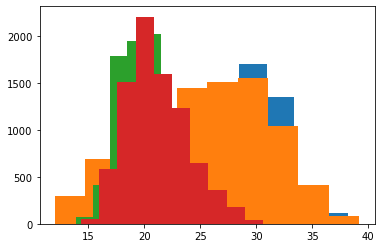

In [190]:
plt.hist(armlegarr['lleg'])
plt.hist(armlegarr['rleg'])
plt.hist(armlegarr['larm'])
plt.hist(armlegarr['rarm'])
plt.show()

# Normalize by body length

In [238]:
for dd in data:
    body = measure_lengths(dd)
    dd /= body['body'] 
#    return skeleton

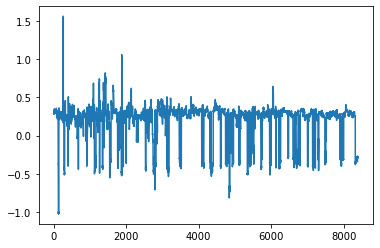

In [239]:
plt.plot(data[:,4])

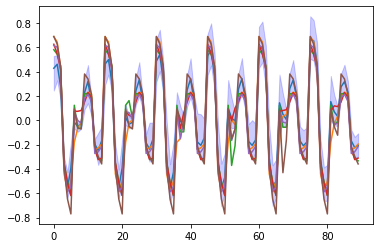

In [257]:
plot_band(xdata)
Nframe = 6

for skarr in test_raw:
    sub = ru.smoothed_frame_N(skarr, 
                            nframe=Nframe, 
                            shift=1)
    new_sks = ru.ravel_rec(sub)[np.newaxis, :]

    this_sk = new_sks[0]
    this_sk = shift_to_zero(this_sk)
    body = measure_lengths(this_sk)
    this_sk /= body['body']

    plt.plot(this_sk[::2])
plt.show()

# Training RF model
## BBS 데이터셋으로 훈련하지만 새로 찍은 스켈레톤 결과도 잘 나와야함. 

In [ ]:
small = True
if small:
    ntrees = 20
    max_depth = 6
else:
    ntrees = 100
    max_depth = 7

In [17]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(data, 
                                                                            label, 
                                                                            test_size=0.7, 
                                                                            stratify=label)

scaler = MinMaxScaler()
# Use whole data to impose stricter boundary condition
X_total = np.concatenate((X_test, X_train))
scaler.fit(X_total)
pickle.dump(scaler, open(f"scaler_{action}_{cam}.pickle", 'wb'))

X_train_normed = scaler.transform(X_train)
X_test_normed = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=ntrees, max_depth=max_depth)
model.fit(X_train_normed, Y_train)

pred = model.predict(X_test_normed)
print("정확도 :{0:.3f}".format(accuracy_score(Y_test, pred)))

pickle.dump(model, open(f"trained_model_{action}_{cam}.pickle", "wb"))

data_to_save = {"train_x":X_train_normed, 
                 "train_y":Y_train,
                 'valid_x':X_test_normed,
                 'valid_y':Y_test}
pickle.dump(data_to_save, open(f"BBS_dataset_{action}_{cam}.pickle", "wb"))

1 (8400, 180)
정확도 :0.874
2 (8380, 180)
정확도 :0.797
3 (8340, 180)
정확도 :0.802
4 (8380, 180)
정확도 :0.860
5 (8360, 180)
정확도 :0.885
6 (8340, 180)
정확도 :0.825
7 (8380, 180)
정확도 :0.769
8 (8380, 180)
정확도 :0.831
9 (8360, 180)
정확도 :0.842
10 (8360, 180)
정확도 :0.798
11 (8360, 180)
정확도 :0.864
12 (8360, 180)
정확도 :0.888
13 (8360, 180)
정확도 :0.886
14 (8380, 180)
정확도 :0.876


In [6]:
import matplotlib.pyplot as plt 

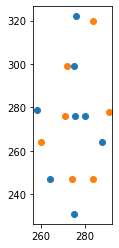

In [7]:
fig, ax = plt.subplots()
ax.scatter(ll[::4], ll[1::4])
ax.scatter(ll[2::4], ll[3::4])

ax.set_aspect("equal")
plt.show()

# Feature trackback

In [126]:
farr = dt.tree_.feature[dt.tree_.feature > 0]

In [127]:
features[farr]

array(['yhead', 'xl_knee', 'yl_hand', 'yl_hip', 'yr_foot', 'yl_shoulder',
       'xhead', 'xl_knee', 'xl_foot', 'xr_foot', 'xl_knee', 'yl_foot',
       'yl_foot', 'xl_knee', 'xl_knee', 'xr_hand', 'xr_hip',
       'yl_shoulder', 'xhead', 'yneck', 'yr_hand', 'xr_foot', 'yr_foot',
       'yl_shoulder', 'xl_foot', 'yr_shoulder', 'ypelvis', 'yr_shoulder',
       'yhead', 'xl_shoulder', 'yl_hip', 'xr_foot', 'xl_hip', 'yl_knee',
       'yr_knee', 'xr_knee', 'yr_foot', 'xl_shoulder', 'xhead',
       'yr_elbow', 'xr_shoulder', 'xr_hip', 'yhead', 'yr_hand', 'yr_hand',
       'xl_shoulder', 'yr_hand', 'yr_knee', 'yl_knee', 'yl_shoulder',
       'yr_foot', 'yhead', 'yr_foot', 'yr_hip', 'xr_shoulder'],
      dtype='<U11')

# Ablation test

# Test with new data

In [208]:
import kinect_utils as ku

import pickle
point_pickle = "/home/hoseung/Work/Kinect/pykinect_BBS/G1/000/BT/bodytracking_data.pickle"
klist = pickle.load(open(point_pickle, "rb"))

scene = ku.kinect2mobile_direct(klist)

nframe = 10 
shift=0
sub = smoothed_frame_N(scene, nframe=nframe, shift=j)
rav_sub = ravel_rec(sub)[np.newaxis, :]
pickle.dump(rav_sub, open("rav_example.pickle", "wb"))

In [206]:
pwd

'/home/hoseung/Work/fhenrf/pose'

In [193]:
model.predict(rav_sub[np.newaxis,:])

array([2])